# Modelo 1

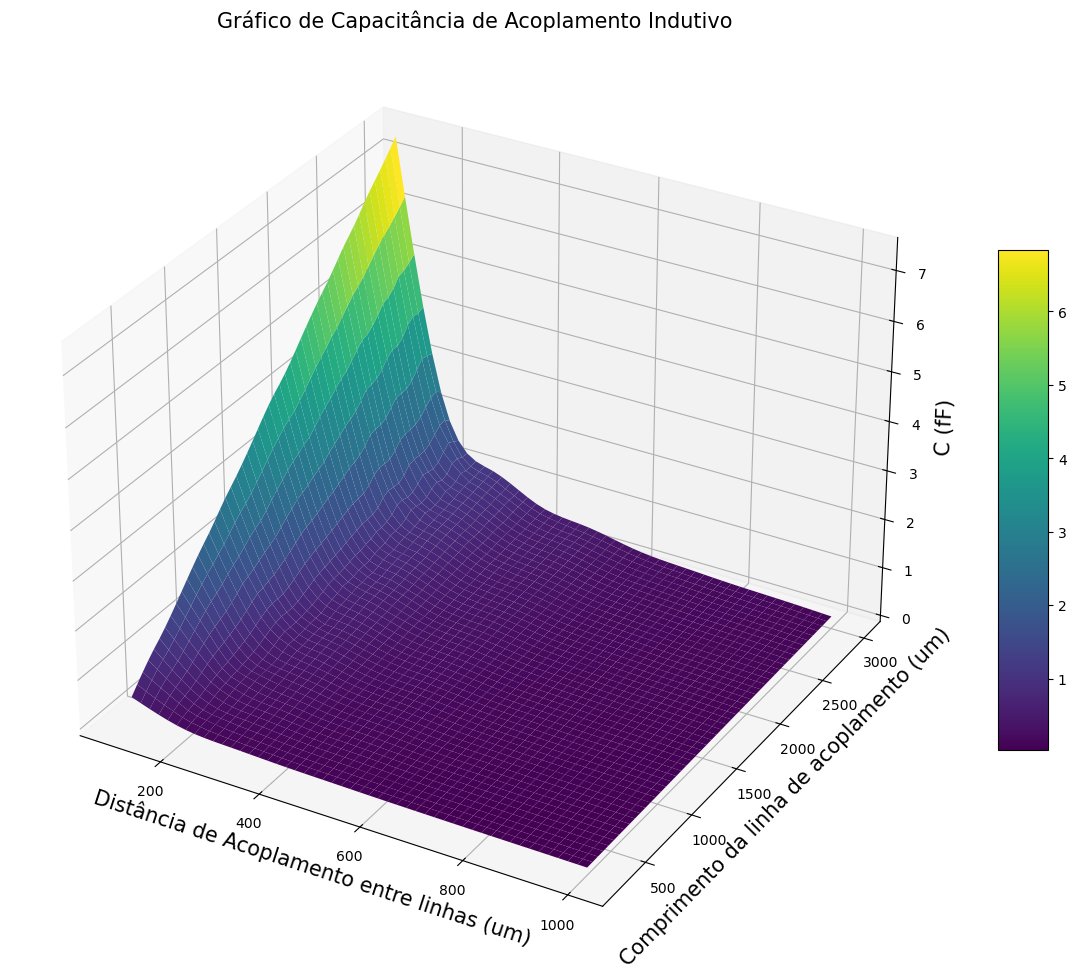

In [1]:
# Método do Diego
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D

# Dados fornecidos
d = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
lc = np.array([250,500,1000,1250,1500,1750,2000,2250,2500,2750,3000])
C_values = np.array([
    [0.51015, 0.20609, 0.12592, 0.09065, 0.0709, 0.05465, 0.04392, 0.03588, 0.03045, 0.02446], #l=0.25mm
    [1.14404, 0.38434, 0.21511, 0.14075, 0.11088, 0.07856, 0.06126, 0.04916, 0.04163, 0.03278], #l=0.5mm
    [2.41352, 0.74523, 0.39571, 0.24401, 0.19187, 0.12725, 0.09706, 0.07728, 0.06445, 0.04967], #l=1mm
    [3.04186, 0.92678, 0.48591, 0.29588, 0.23257, 0.15248, 0.11528, 0.09151, 0.07714, 0.05883], #l=1.25mm
    [3.67349, 1.10375, 0.57491, 0.34744, 0.27107, 0.17531, 0.13221, 0.10546, 0.08802, 0.06744], #l=1.5mm
    [4.30633, 1.28996, 0.66852, 0.40033, 0.31182, 0.20209, 0.15226, 0.12073, 0.10165, 0.07709], #l=1.75mm
    [4.94134, 1.47223, 0.75957, 0.45391, 0.35432, 0.22717, 0.1712, 0.13553, 0.11341, 0.08626], #l=2mm
    [5.57507, 1.65591, 0.85103, 0.50732, 0.39339, 0.2524, 0.1899, 0.15031, 0.12584, 0.09583], #l=2.25mm
    [6.21497, 1.84003, 0.94395, 0.56107, 0.43274, 0.27844, 0.20852, 0.16463, 0.13878, 0.10497], #l=2.5mm
    [6.86023, 2.02414, 1.03626, 0.61402, 0.47439, 0.30284, 0.22848, 0.18013, 0.15111, 0.11367], #l=2.75mm
    [7.48684, 2.20653, 1.12897, 0.66739, 0.51423, 0.3286, 0.24655, 0.19499, 0.16422, 0.12288] #l=3mm
]).T

# Criando a grade de interpolação
D, Lc = np.meshgrid(np.linspace(d.min(), d.max(), 50), np.linspace(lc.min(), lc.max(), 50))
points = np.array([(di, lci) for di in d for lci in lc])
values = C_values.flatten()
C_interp = griddata(points, values, (D, Lc), method='cubic')

# Criando a figura 3D
fig = plt.figure(figsize=(15, 13))
ax = fig.add_subplot(111, projection='3d')

# Plotando a superfície interpolada
surf = ax.plot_surface(D, Lc, C_interp, cmap='viridis', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

# Rótulos dos eixos
ax.set_xlabel('Distância de Acoplamento entre linhas (um)', fontsize=15)
ax.set_ylabel('Comprimento da linha de acoplamento (um)', fontsize=15)
ax.set_zlabel('C (fF)', fontsize=15)
ax.set_title('Gráfico de Capacitância de Acoplamento Indutivo', fontsize=15)

# Exibindo o gráfico
plt.show()

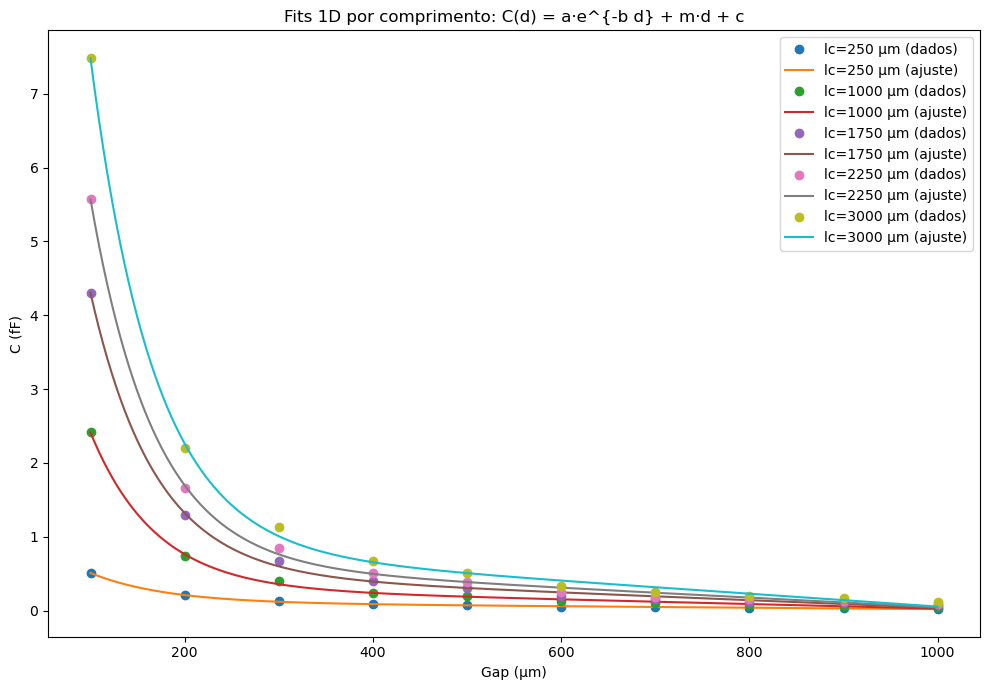


Parâmetros globais (modelo 2D):
  a0 = 3.10966e-20
  a1 = 0.00960434
  b0 = 0.0151952
  b1 = -1.75786e-07
  m0 = 1.34265e-05
  m1 = -3.00498e-07
  c0 = 0.0136835
  c1 = 0.000307601
R² global = 0.99918


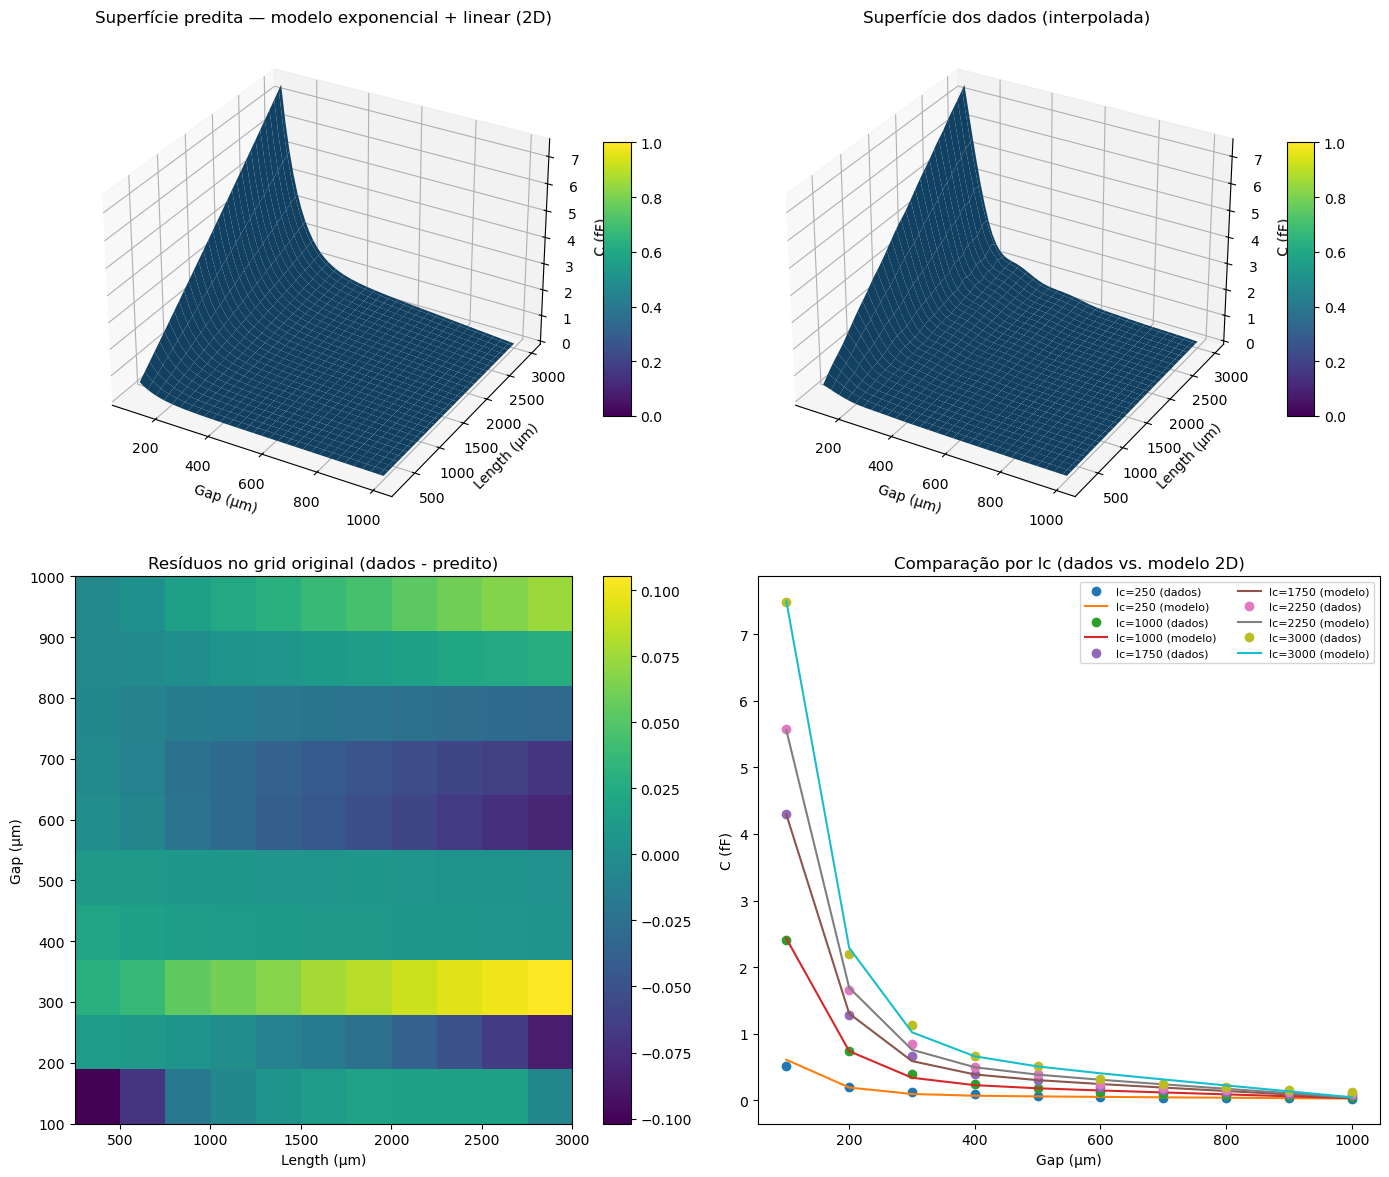

In [ ]:
# ==== FIT exponencial + linear (1D por lc e 2D global) ====
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --- Seus dados (já definidos acima) ---
# d  -> gaps (um), shape (Nd,)
# lc -> lengths (um), shape (Nl,)
# C_values -> matriz com linhas = d (Nd) e colunas = lc (Nl)

Nd, Nl = C_values.shape
assert Nd == d.size and Nl == lc.size, "Shapes inconsistentes entre C_values, d e lc."

# =========================================
# 1) FIT 1D por length: C(d) = a*exp(-b*d) + m*d + c
# =========================================
def model_1d(d_, a, b, m, c):
    return a * np.exp(-b * d_) + m * d_ + c

fits_1d = []
for j, lval in enumerate(lc):
    y = C_values[:, j]
    # chutes iniciais razoáveis
    a0 = max(y.max() - y.min(), 1e-3)
    b0 = 1/300.0  # decaimento típico em ~300um; ajuste livre depois
    m0 = (y[-1]-y[0]) / (d[-1]-d[0])
    c0 = y.min()
    p0 = [a0, b0, m0, c0]
    # impor b>0 para evitar crescimento exponencial
    bounds = ([0, 1e-9, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])
    popt, pcov = curve_fit(model_1d, d, y, p0=p0, bounds=bounds, maxfev=100000)
    fits_1d.append((lval, popt))

# --- Plot 1D (alguns comprimentos para não poluir)
plt.figure(figsize=(10, 7))
subset = np.linspace(0, Nl-1, min(Nl, 5), dtype=int)  # até 5 curvas
for j in subset:
    y = C_values[:, j]
    popt = [p for L, p in fits_1d if np.isclose(L, lc[j])][0]
    d_dense = np.linspace(d.min(), d.max(), 400)
    plt.plot(d, y, "o", label=f"lc={lc[j]} µm (dados)")
    plt.plot(d_dense, model_1d(d_dense, *popt), "-", label=f"lc={lc[j]} µm (ajuste)")
plt.xlabel("Gap (µm)")
plt.ylabel("C (fF)")
plt.title("Fits 1D por comprimento: C(d) = a·e^{-b d} + m·d + c")
plt.legend()
plt.tight_layout()
plt.show()

# =========================================
# 2) FIT 2D global:
#    A(l)=a0+a1 l, B(l)=b0+b1 l, M(l)=m0+m1 l, C0(l)=c0+c1 l
#    C(d,l) = A(l) exp(-B(l) d) + M(l) d + C0(l)
# =========================================
def model_2d_flat(X, a0,a1, b0,b1, m0,m1, c0,c1):
    d_, l_ = X  # shapes iguais; retornaremos ravel
    A = a0 + a1*l_
    B = b0 + b1*l_
    M = m0 + m1*l_
    Cc = c0 + c1*l_
    return (A*np.exp(-B*d_) + M*d_ + Cc).ravel()

# preparar dados "longos"
D_grid, L_grid = np.meshgrid(d, lc, indexing="ij")  # (Nd, Nl)
Y = C_values.ravel()

# chutes iniciais (a partir dos fits 1D anteriores)
a_list, b_list, m_list, c_list = zip(*[p for L, p in fits_1d])
a0_init = max(np.mean(a_list), 1e-6)
b0_init = max(np.mean(b_list), 1e-6)
m0_init = np.mean(m_list)
c0_init = np.mean(c_list)
p0_global = [a0_init, 0.0, b0_init, 0.0, m0_init, 0.0, c0_init, 0.0]  # 8 parâmetros

# BOUNDS corretos (mesmo comprimento de p0_global)
lower = [0.0, -np.inf, 1e-9, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf]
upper = [np.inf,  np.inf,  np.inf,  np.inf,  np.inf,  np.inf,  np.inf,  np.inf]

popt2, pcov2 = curve_fit(
    model_2d_flat, (D_grid, L_grid), Y,
    p0=p0_global, bounds=(lower, upper), method="trf", maxfev=200000
)

# métricas
Y_hat = model_2d_flat((D_grid, L_grid), *popt2)
ss_res = np.sum((Y - Y_hat)**2)
ss_tot = np.sum((Y - np.mean(Y))**2)
r2 = 1 - ss_res/ss_tot

print("\nParâmetros globais (modelo 2D):")
labels = ["a0","a1","b0","b1","m0","m1","c0","c1"]
for name, val in zip(labels, popt2):
    print(f"  {name:>2} = {val:.6g}")
print(f"R² global = {r2:.5f}")

# --- Superfície predita e comparação visual ---
# Malha densa:
d_dense = np.linspace(d.min(), d.max(), 60)
l_dense = np.linspace(lc.min(), lc.max(), 60)
D_dense, L_dense = np.meshgrid(d_dense, l_dense, indexing="ij")
C_pred_dense = model_2d_flat((D_dense, L_dense), *popt2).reshape(D_dense.shape)

# Interpolar dados para a malha densa (só para comparação visual)
points = np.column_stack([D_grid.ravel(), L_grid.ravel()])
C_interp_dense = griddata(points, C_values.ravel(), (D_dense, L_dense), method="cubic")

# Plot 3D da superfície ajustada
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(221, projection="3d")
surf = ax.plot_surface(D_dense, L_dense, C_pred_dense, edgecolor="none")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel("Gap (µm)")
ax.set_ylabel("Length (µm)")
ax.set_zlabel("C (fF)")
ax.set_title("Superfície predita — modelo exponencial + linear (2D)")

# Plot 3D dos dados interpolados (para comparar)
ax2 = fig.add_subplot(222, projection="3d")
surf2 = ax2.plot_surface(D_dense, L_dense, C_interp_dense, edgecolor="none")
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
ax2.set_xlabel("Gap (µm)")
ax2.set_ylabel("Length (µm)")
ax2.set_zlabel("C (fF)")
ax2.set_title("Superfície dos dados (interpolada)")

# Mapa de resíduos (dados - predito) na malha de dados original
residuals = (C_values - model_2d_flat((D_grid, L_grid), *popt2).reshape(D_grid.shape))
ax3 = fig.add_subplot(223)
im = ax3.imshow(residuals, origin="lower",
                extent=[lc.min(), lc.max(), d.min(), d.max()],
                aspect="auto")
fig.colorbar(im, ax=ax3)
ax3.set_xlabel("Length (µm)")
ax3.set_ylabel("Gap (µm)")
ax3.set_title("Resíduos no grid original (dados - predito)")

# Curvas C(d) para alguns lengths comparando dados vs. global-fit
ax4 = fig.add_subplot(224)
for j in np.linspace(0, Nl-1, min(Nl, 5), dtype=int):
    y = C_values[:, j]
    yhat = model_2d_flat((d, np.full_like(d, lc[j])), *popt2)
    ax4.plot(d, y, "o", label=f"lc={lc[j]:.0f} (dados)")
    ax4.plot(d, yhat, "-", label=f"lc={lc[j]:.0f} (modelo)")
ax4.set_xlabel("Gap (µm)")
ax4.set_ylabel("C (fF)")
ax4.set_title("Comparação por lc (dados vs. modelo 2D)")
ax4.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()


# Modelo 2


In [22]:
# -*- coding: utf-8 -*-
# Varre todos os .txt na pasta "Modelo 3", extrai C[trace_CAP32][trace_CAP31] por gap
# e acrescenta a coluna length_mm (extraído do nome do arquivo). Gera um CSV agregando tudo.

import re
import json
import pandas as pd
from pathlib import Path

# ======== CONFIG: ajuste só esta linha se sua pasta for outra ========
base_dir = Path("/Users/valentinaspohr/Desktop/tudo/unicamp/2s:2024/rouxinol/Projeto-Valentina-main 10/Inductive couplers/Modelo 2")

# ======== HELPERS ========
def parse_matrix_block(mat_text: str):
    """Lê a matriz impressa em texto:
       1ª linha = cabeçalhos (ex.: ground_main_plane trace_CAP31 trace_CAP32)
       Demais = 'row_label  n1  n2  n3' """
    lines = [ln.rstrip() for ln in mat_text.strip().splitlines() if ln.strip()]
    if not lines:
        return None
    header = re.split(r"\s+", lines[0].strip())
    table = {}
    for ln in lines[1:]:
        parts = re.split(r"\s+", ln.strip())
        if len(parts) >= 4:
            row_label = parts[0]
            vals = [float(x) for x in parts[1:4]]
            table[row_label] = dict(zip(header, vals))
    return table

def extract_c22_c21_from_matrix(mat_text: str):
    """Retorna explicitamente C[trace_CAP22][trace_CAP21]."""
    tb = parse_matrix_block(mat_text)
    if not tb:
        return float("nan")
    return tb.get("trace_CAP22", {}).get("trace_CAP21", float("nan"))

def extract_length_from_name(name: str):
    m = re.search(r"length\s*=\s*([0-9]*\.?[0-9]+)\s*mm", name, flags=re.I)
    return float(m.group(1)) if m else None

# ======== LOOP EM TODOS OS .TXT ========
records = []
txt_files = sorted(base_dir.glob("*.txt"))

for file_path in txt_files:
    text = file_path.read_text(encoding="utf-8", errors="ignore")
    length_mm = extract_length_from_name(file_path.name)

    # Percorre todos os blocos "XXum:" e pega o bloco de 'capacitance': ( ... , 'fF')
    idx = 0
    while True:
        m_gap = re.search(r"(\d+)\s*um\s*:", text[idx:], flags=re.I)
        if not m_gap:
            break
        gap_um = int(m_gap.group(1))
        start = idx + m_gap.end()

        m_mat = re.search(
            r"capacitance'\s*:\s*\(\s*(.*?)\s*,\s*['\"]fF['\"]\s*\)",
            text[start:], flags=re.S | re.I
        )
        if not m_mat:
            # avança para procurar o próximo gap
            idx = start
            continue

        mat_text = m_mat.group(1)
        C_cross = extract_c22_c21_from_matrix(mat_text)  # CAP32 ↔ CAP31

        records.append({
            "source_file": file_path.name,
            "length_mm": length_mm,
            "gap_um": gap_um,
            "C_trace_CAP22__trace_CAP21_fF": C_cross,
        })

        # avança o cursor após o bloco de capacitância encontrado
        idx = start + m_mat.end()

# ======== DF FINAL ========
df = pd.DataFrame.from_records(records)
# ordena por arquivo, depois length, depois gap
if not df.empty:
    df = df.sort_values(["source_file", "length_mm", "gap_um"], kind="mergesort").reset_index(drop=True)

display({"n_files": len(txt_files), "rows": len(df)})
df
# -*- coding: utf-8 -*-
# Varre todos os .txt na pasta "Modelo 3", extrai C[trace_CAP32][trace_CAP31] por gap
# e acrescenta a coluna length_mm (extraído do nome do arquivo). Gera um CSV agregando tudo.

import re
import json
import pandas as pd
from pathlib import Path

# ======== CONFIG: ajuste só esta linha se sua pasta for outra ========
base_dir = Path("/Users/valentinaspohr/Desktop/tudo/unicamp/2s:2024/rouxinol/Projeto-Valentina-main 10/Inductive couplers/Modelo 2")

# ======== HELPERS ========
def parse_matrix_block(mat_text: str):
    """Lê a matriz impressa em texto:
       1ª linha = cabeçalhos (ex.: ground_main_plane trace_CAP21 trace_CAP22)
       Demais = 'row_label  n1  n2  n3' """
    lines = [ln.rstrip() for ln in mat_text.strip().splitlines() if ln.strip()]
    if not lines:
        return None
    header = re.split(r"\s+", lines[0].strip())
    table = {}
    for ln in lines[1:]:
        parts = re.split(r"\s+", ln.strip())
        if len(parts) >= 4:
            row_label = parts[0]
            vals = [float(x) for x in parts[1:4]]
            table[row_label] = dict(zip(header, vals))
    return table

def extract_c22_c21_from_matrix(mat_text: str):
    """Retorna explicitamente C[trace_CAP32][trace_CAP31]."""
    tb = parse_matrix_block(mat_text)
    if not tb:
        return float("nan")
    return tb.get("trace_CAP22", {}).get("trace_CAP21", float("nan"))

def extract_length_from_name(name: str):
    m = re.search(r"length\s*=\s*([0-9]*\.?[0-9]+)\s*mm", name, flags=re.I)
    return float(m.group(1)) if m else None

# ======== LOOP EM TODOS OS .TXT ========
records = []
txt_files = sorted(base_dir.glob("*.txt"))

for file_path in txt_files:
    text = file_path.read_text(encoding="utf-8", errors="ignore")
    length_mm = extract_length_from_name(file_path.name)

    # Percorre todos os blocos "XXum:" e pega o bloco de 'capacitance': ( ... , 'fF')
    idx = 0
    while True:
        m_gap = re.search(r"(\d+)\s*um\s*:", text[idx:], flags=re.I)
        if not m_gap:
            break
        gap_um = int(m_gap.group(1))
        start = idx + m_gap.end()

        m_mat = re.search(
            r"capacitance'\s*:\s*\(\s*(.*?)\s*,\s*['\"]fF['\"]\s*\)",
            text[start:], flags=re.S | re.I
        )
        if not m_mat:
            # avança para procurar o próximo gap
            idx = start
            continue

        mat_text = m_mat.group(1)
        C_cross = extract_c22_c21_from_matrix(mat_text)  # CAP32 ↔ CAP31

        records.append({
            "source_file": file_path.name,
            "length_mm": length_mm,
            "gap_um": gap_um,
            "C_trace_CAP22__trace_CAP21_fF": C_cross,
        })

        # avança o cursor após o bloco de capacitância encontrado
        idx = start + m_mat.end()

# ======== DF FINAL ========
df = pd.DataFrame.from_records(records)
# ordena por arquivo, depois length, depois gap
if not df.empty:
    df = df.sort_values(["source_file", "length_mm", "gap_um"], kind="mergesort").reset_index(drop=True)

display({"n_files": len(txt_files), "rows": len(df)})
df


{'n_files': 20, 'rows': 250}

{'n_files': 20, 'rows': 250}

source_file  length_mm  gap_um  \
0    Modelo 2, length=0.5mm, gap=10-300um.txt        0.5    1725   
1    Modelo 2, length=0.5mm, gap=10-300um.txt        0.5    1750   
2    Modelo 2, length=0.5mm, gap=10-300um.txt        0.5    1775   
3    Modelo 2, length=0.5mm, gap=10-300um.txt        0.5    1825   
4    Modelo 2, length=0.5mm, gap=10-300um.txt        0.5    1850   
..                                        ...        ...     ...   
245                  Modelo 2, length=3mm.txt        3.0    1600   
246                  Modelo 2, length=3mm.txt        3.0    1700   
247                  Modelo 2, length=3mm.txt        3.0    1800   
248                  Modelo 2, length=3mm.txt        3.0    1900   
249                  Modelo 2, length=3mm.txt        3.0    1990   

     C_trace_CAP22__trace_CAP21_fF  
0                         -0.40851  
1                         -0.45965  
2                         -0.51867  
3                         -0.68310  
4                         -0.83464  
..                             ...  
245                       -0.78173  
246                       -1.26830  
247                       -2.46662  
248                       -7.56044  
249                     -180.13342  

[250 rows x 4 columns]

In [23]:
import numpy as np
import pandas as pd

# partindo do DataFrame df já processado
df2 = df.copy()
df2["gap_um"] = 2000 - df2["gap_um"]                # aplica transformação
df2["cap_fF"] = df2["C_trace_CAP22__trace_CAP21_fF"].abs()  # valores positivos
df2["length_um"] = (df2["length_mm"] * 1000).astype(int)

# gaps únicos e lengths únicos
d2  = np.sort(df2["gap_um"].astype(int))
lc2 = np.sort(df2["length_um"].astype(int))

# pivot: linhas = gaps, colunas = lengths
pivot = df2.pivot_table(index="gap_um", columns="length_um", values="cap_fF", aggfunc="first")
pivot = pivot.reindex(index=d2, columns=lc2)   # garante ordem

C_values2 = pivot.to_numpy()   # shape (len(d2), len(lc2))

print("d2 =", d2)
print("lc2 =", lc2)
print("C_values2 shape:", C_values2)


d2 = [  10   10   10   10   10   10   10   10   10   10   20   20   20   20
   20   20   20   20   20   20   30   30   30   30   30   30   30   30
   30   30   40   40   40   40   40   40   40   40   40   40   50   50
   50   50   50   50   50   50   50   50   60   60   60   60   60   60
   60   60   60   60   70   70   70   70   70   70   70   70   70   70
   80   80   80   80   80   80   80   80   80   80   90   90   90   90
   90   90   90   90   90   90  100  100  100  100  100  100  100  100
  100  100  125  125  125  125  125  125  125  125  125  125  150  150
  150  150  150  150  150  150  150  150  175  175  175  175  175  175
  175  175  175  175  200  200  200  200  200  200  200  200  200  200
  225  225  225  225  225  225  225  225  225  225  250  250  250  250
  250  250  250  250  250  250  275  275  275  275  275  275  275  275
  275  275  300  300  300  300  300  300  300  300  300  300  400  400
  400  400  400  400  400  400  400  400  500  500  500  500  500  500
 

d3 (gaps) -> (25,)  | lc3 (lengths) -> (10,)  | C_values3 -> (25, 10)


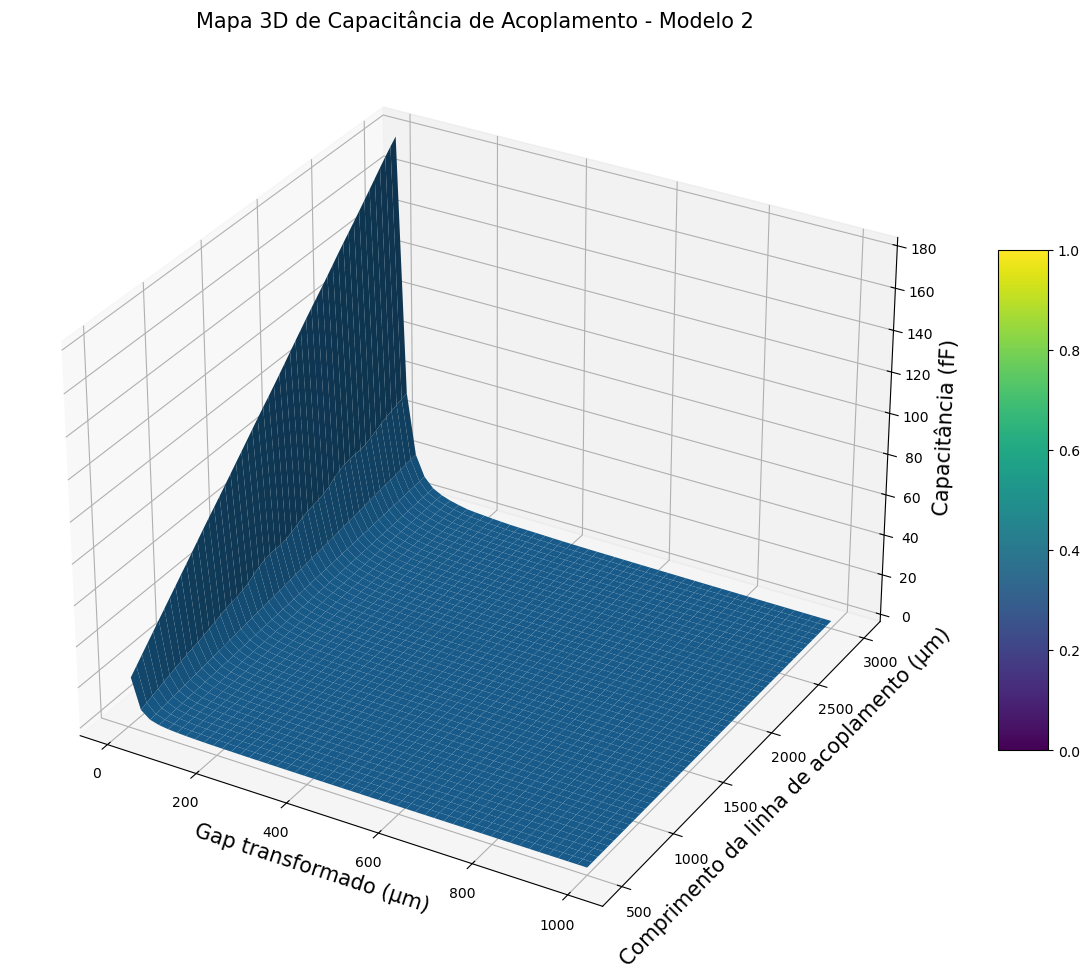

In [24]:
# ==== construir d3, lc3, C_values3 a partir do df ====
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Partindo do DataFrame df com colunas:
# 'length_mm', 'gap_um', 'C_trace_CAP22__trace_CAP21_fF'
df2 = df.copy()

# 1) transformar gap e deixar capacitância positiva
df2["gap_um"] = 2000 - df2["gap_um"]                             # gap transformado
df2["cap_fF"] = df2["C_trace_CAP22__trace_CAP21_fF"].abs()       # positivos
df2["length_um"] = (df2["length_mm"] * 1000).round().astype(int) # mm -> µm

# 2) montar e ordenar eixos
d3  = np.sort(df2["gap_um"].unique().astype(int))   # gaps (µm) transformados
lc3 = np.sort(df2["length_um"].unique().astype(int))# lengths (µm)

# 3) pivotar para matriz (linhas=gaps, colunas=lengths)
pivot = df2.pivot_table(index="gap_um", columns="length_um", values="cap_fF", aggfunc="first")
pivot = pivot.reindex(index=d3, columns=lc3)
C_values3 = pivot.to_numpy(dtype=float)             # shape: (len(d3), len(lc3))

print("d3 (gaps) ->", d3.shape, " | lc3 (lengths) ->", lc3.shape, " | C_values3 ->", C_values3.shape)

# ==== Método do Diego (com os valores acima) ====

# Grade regular para interpolação
D, Lc = np.meshgrid(
    np.linspace(d3.min(),  d3.max(),  50),   # eixo gaps (µm) transformados
    np.linspace(lc3.min(), lc3.max(), 50)    # eixo lengths (µm)
)

# Pontos conhecidos (casados com o shape de C_values3)
D_pts, Lc_pts = np.meshgrid(d3, lc3, indexing='ij')  # D_pts: (len(d3), len(lc3))
points = np.column_stack([D_pts.ravel(), Lc_pts.ravel()])
values = C_values3.ravel()

# Interpolação
C_interp = griddata(points, values, (D, Lc), method='cubic')

# Plot
fig = plt.figure(figsize=(15, 13))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(D, Lc, C_interp, edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

ax.set_xlabel('Gap transformado (µm)', fontsize=15)
ax.set_ylabel('Comprimento da linha de acoplamento (µm)', fontsize=15)
ax.set_zlabel('Capacitância (fF)', fontsize=15)
ax.set_title('Mapa 3D de Capacitância de Acoplamento - Modelo 2', fontsize=15)
plt.show()


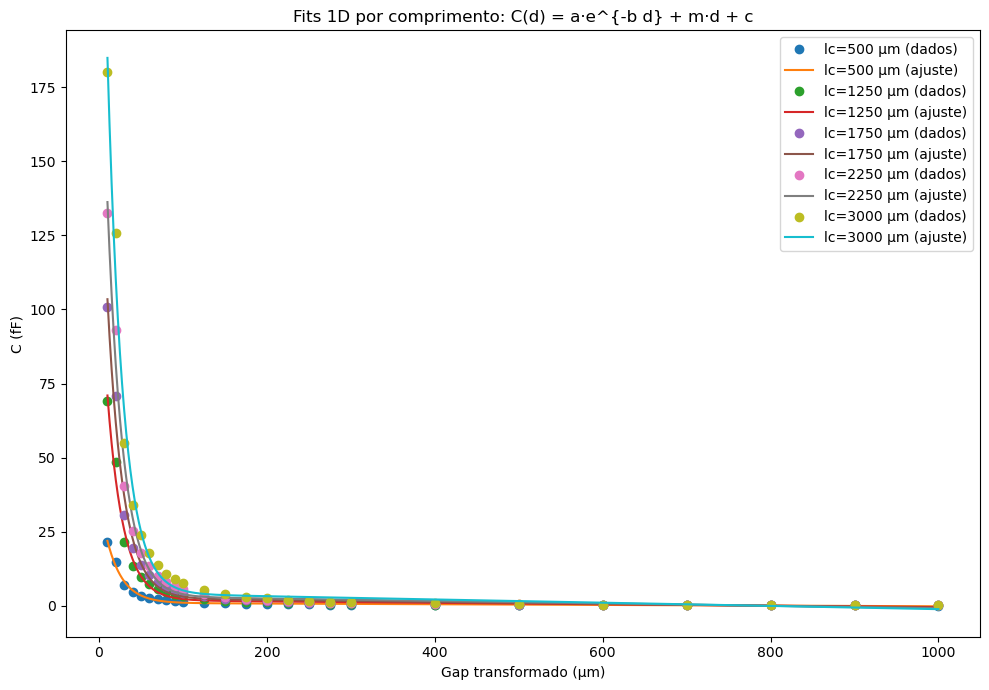


Parâmetros globais (modelo 2D):
  a0 = 1.62129e-07
  a1 = 0.100845
  b0 = 0.0592123
  b1 = -2.29999e-06
  m0 = 0.000600864
  m1 = -2.1275e-06
  c0 = -0.201206
  c1 = 0.00156082
R² global = 0.98849


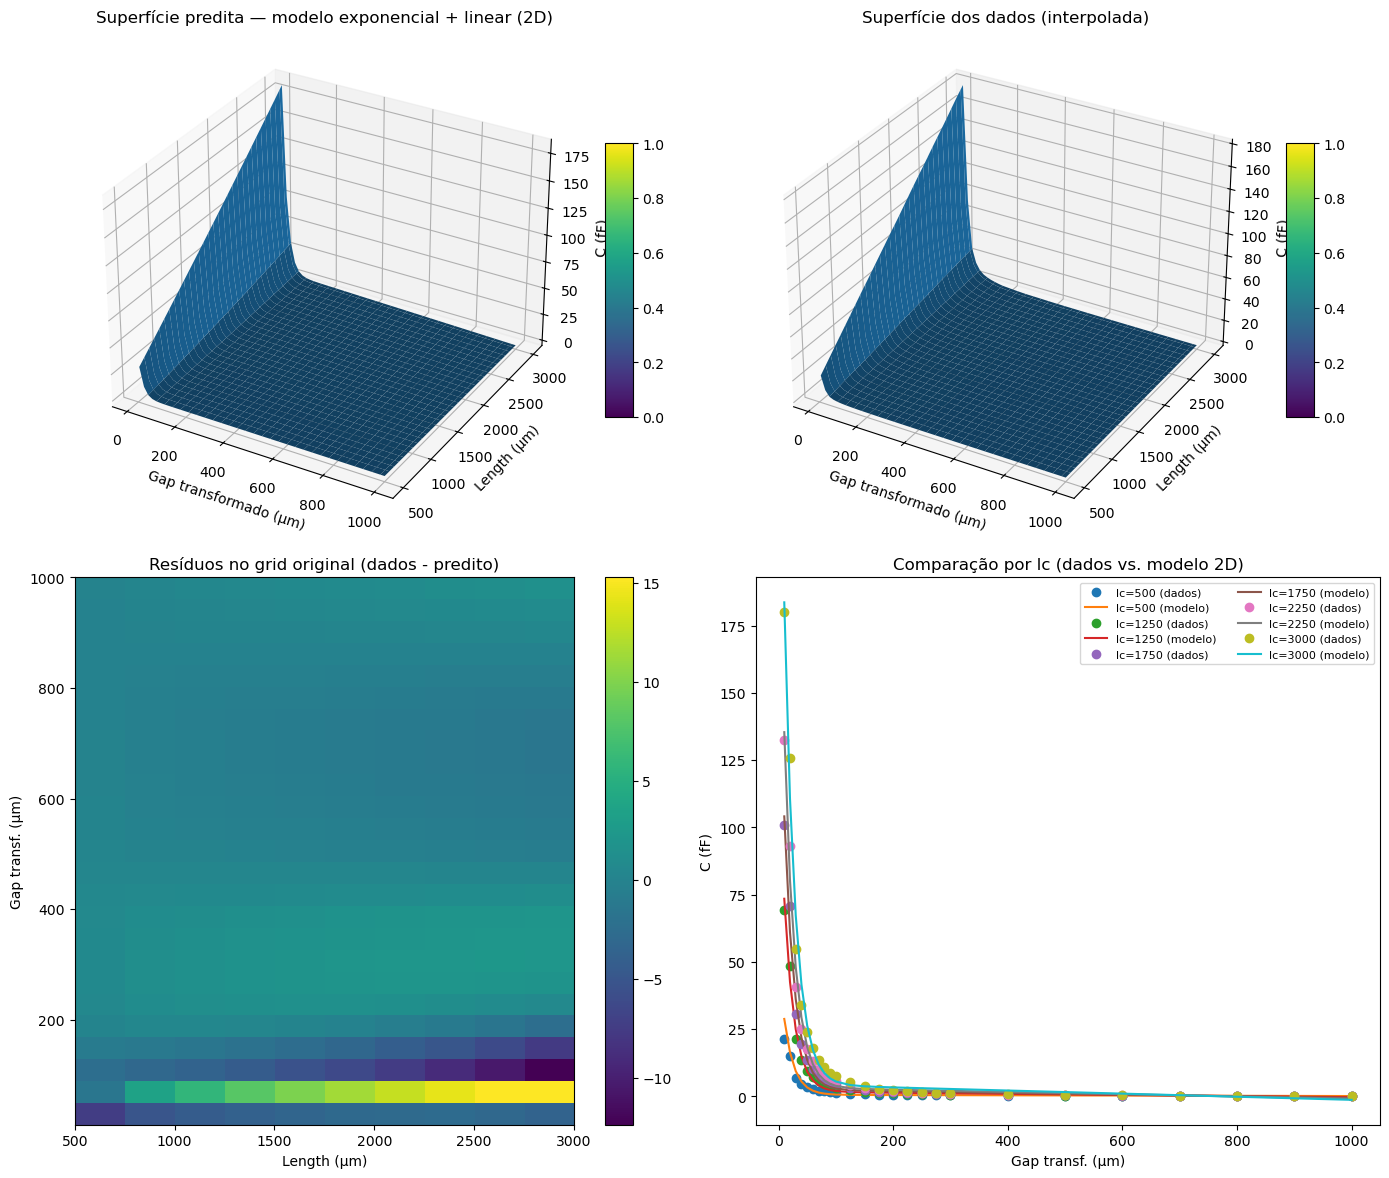

In [31]:
# ==== FIT exponencial + linear para d3, lc3, C_values3 ====
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---- Dados já construídos anteriormente ----
# d3: gaps transformados (µm)   shape (Nd,)
# lc3: comprimentos (µm)        shape (Nl,)
# C_values3: matriz C           shape (Nd, Nl)  (linhas = d3, colunas = lc3)

Nd, Nl = C_values3.shape
assert Nd == d3.size and Nl == lc3.size, "Shapes inconsistentes entre C_values3, d3 e lc3."

# =========================================
# 1) FIT 1D por lc: C(d) = a*exp(-b*d) + m*d + c
# =========================================
def model_1d(d_, a, b, m, c):
    return a * np.exp(-b * d_) + m * d_ + c

fits_1d = []
for j, lval in enumerate(lc3):
    y = C_values3[:, j]
    a0 = max(y.max() - y.min(), 1e-6)
    b0 = 1/300.0  # chute típico
    m0 = (y[-1]-y[0]) / (d3[-1]-d3[0])
    c0 = y.min()
    p0 = [a0, b0, m0, c0]
    bounds = ([0.0, 1e-9, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])
    popt, pcov = curve_fit(model_1d, d3, y, p0=p0, bounds=bounds, maxfev=100000)
    fits_1d.append((lval, popt))

# Plot 1D para até 5 comprimentos
plt.figure(figsize=(10, 7))
subset = np.linspace(0, Nl-1, min(Nl, 5), dtype=int)
for j in subset:
    y = C_values3[:, j]
    popt = [p for L, p in fits_1d if np.isclose(L, lc3[j])][0]
    d_dense = np.linspace(d3.min(), d3.max(), 400)
    plt.plot(d3, y, "o", label=f"lc={lc3[j]} µm (dados)")
    plt.plot(d_dense, model_1d(d_dense, *popt), "-",
             label=f"lc={lc3[j]} µm (ajuste)")
plt.xlabel("Gap transformado (µm)")
plt.ylabel("C (fF)")
plt.title("Fits 1D por comprimento: C(d) = a·e^{-b d} + m·d + c")
plt.legend()
plt.tight_layout()
plt.show()

# =========================================
# 2) FIT 2D global:
#    A(l)=a0+a1 l, B(l)=b0+b1 l, M(l)=m0+m1 l, C0(l)=c0+c1 l
#    C(d,l) = A(l) exp(-B(l) d) + M(l) d + C0(l)
# =========================================
def model_2d_flat(X, a0,a1, b0,b1, m0,m1, c0,c1):
    d_, l_ = X
    A = a0 + a1*l_
    B = b0 + b1*l_
    M = m0 + m1*l_
    Cc = c0 + c1*l_
    return (A*np.exp(-B*d_) + M*d_ + Cc).ravel()

# preparar dados no grid original
D_grid, L_grid = np.meshgrid(d3, lc3, indexing="ij")  # (Nd, Nl)
Y = C_values3.ravel()

# chutes iniciais a partir da média dos fits 1D
a_list, b_list, m_list, c_list = zip(*[p for L, p in fits_1d])
a0_init = max(np.mean(a_list), 1e-6)
b0_init = max(np.mean(b_list), 1e-6)
m0_init = np.mean(m_list)
c0_init = np.mean(c_list)
p0_global = [a0_init, 0.0, b0_init, 0.0, m0_init, 0.0, c0_init, 0.0]

# bounds corretos (tupla)
lower = [0.0, -np.inf, 1e-9, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf]
upper = [np.inf,  np.inf,  np.inf,  np.inf,  np.inf,  np.inf,  np.inf,  np.inf]
popt2, pcov2 = curve_fit(
    model_2d_flat, (D_grid, L_grid), Y,
    p0=p0_global, bounds=(lower, upper), method="trf", maxfev=200000
)

# métricas
Y_hat = model_2d_flat((D_grid, L_grid), *popt2)
ss_res = np.sum((Y - Y_hat)**2)
ss_tot = np.sum((Y - np.mean(Y))**2)
r2 = 1 - ss_res/ss_tot

print("\nParâmetros globais (modelo 2D):")
labels = ["a0","a1","b0","b1","m0","m1","c0","c1"]
for name, val in zip(labels, popt2):
    print(f"  {name:>2} = {val:.6g}")
print(f"R² global = {r2:.5f}")

# ----- visualização 3D: superfície predita vs. dados (interpolados) -----
d_dense = np.linspace(d3.min(), d3.max(), 60)
l_dense = np.linspace(lc3.min(), lc3.max(), 60)
D_dense, L_dense = np.meshgrid(d_dense, l_dense, indexing="ij")
C_pred_dense = model_2d_flat((D_dense, L_dense), *popt2).reshape(D_dense.shape)

# Interpolar dados para comparar (só visual)
points = np.column_stack([D_grid.ravel(), L_grid.ravel()])
C_interp_dense = griddata(points, C_values3.ravel(), (D_dense, L_dense), method="cubic")

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(221, projection="3d")
surf = ax.plot_surface(D_dense, L_dense, C_pred_dense, edgecolor="none")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel("Gap transformado (µm)")
ax.set_ylabel("Length (µm)")
ax.set_zlabel("C (fF)")
ax.set_title("Superfície predita — modelo exponencial + linear (2D)")

ax2 = fig.add_subplot(222, projection="3d")
surf2 = ax2.plot_surface(D_dense, L_dense, C_interp_dense, edgecolor="none")
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
ax2.set_xlabel("Gap transformado (µm)")
ax2.set_ylabel("Length (µm)")
ax2.set_zlabel("C (fF)")
ax2.set_title("Superfície dos dados (interpolada)")

# Resíduos no grid original
residuals = (C_values3 - model_2d_flat((D_grid, L_grid), *popt2).reshape(D_grid.shape))
ax3 = fig.add_subplot(223)
im = ax3.imshow(residuals, origin="lower",
                extent=[lc3.min(), lc3.max(), d3.min(), d3.max()],
                aspect="auto")
fig.colorbar(im, ax=ax3)
ax3.set_xlabel("Length (µm)")
ax3.set_ylabel("Gap transf. (µm)")
ax3.set_title("Resíduos no grid original (dados - predito)")

# Curvas C(d) para alguns lengths comparando dados vs. global-fit
ax4 = fig.add_subplot(224)
for j in np.linspace(0, Nl-1, min(Nl, 5), dtype=int):
    y = C_values3[:, j]
    yhat = model_2d_flat((d3, np.full_like(d3, lc3[j])), *popt2)
    ax4.plot(d3, y, "o", label=f"lc={lc3[j]:.0f} (dados)")
    ax4.plot(d3, yhat, "-", label=f"lc={lc3[j]:.0f} (modelo)")
ax4.set_xlabel("Gap transf. (µm)")
ax4.set_ylabel("C (fF)")
ax4.set_title("Comparação por lc (dados vs. modelo 2D)")
ax4.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()


# Modelo 3

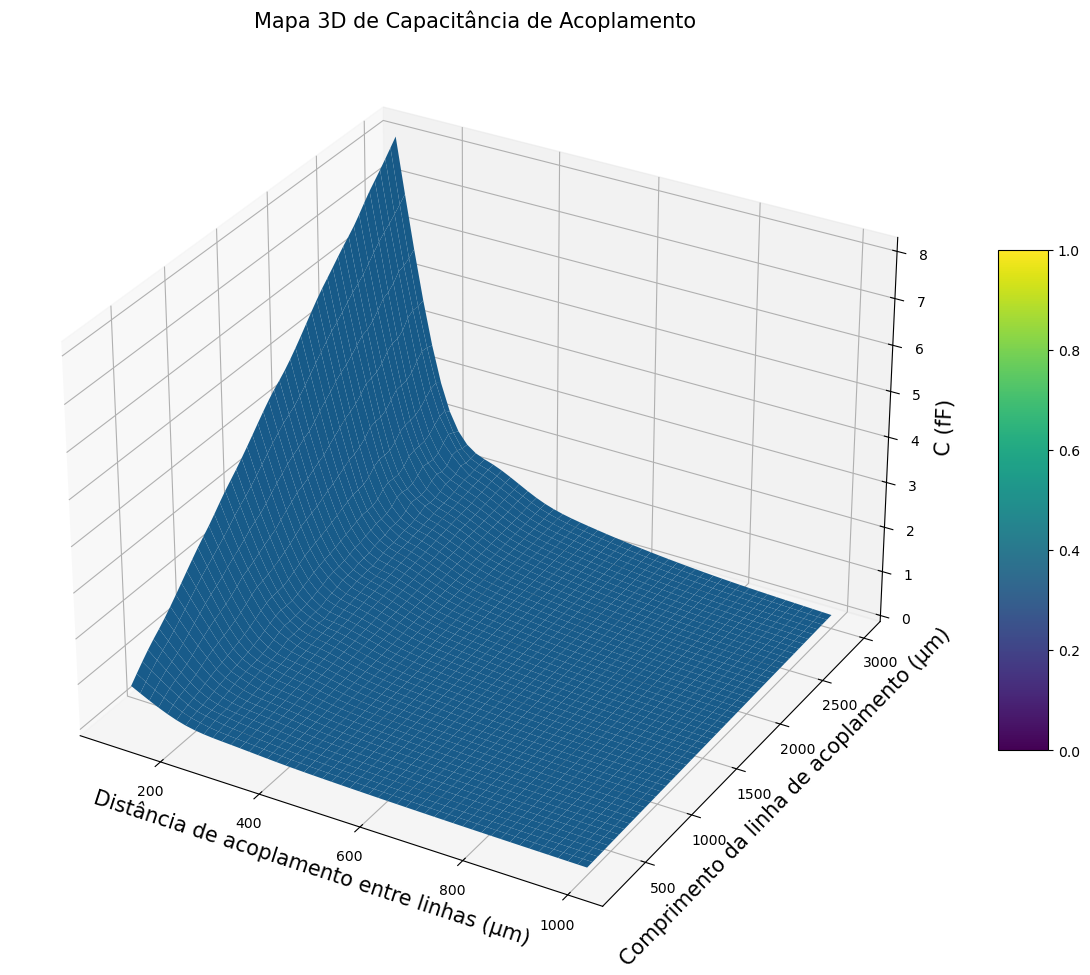

In [18]:
# Método do Diego (corrigido)
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

d3  = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])       # gaps (µm)
lc3 = np.array([250, 500, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000])  # lengths (µm)

# >>> CONVERTA PARA np.array ANTES DE .T <<<
C_values3 = np.array([
    [0.80594, 0.33563, 0.20327, 0.14086, 0.10294, 0.07935, 0.06192, 0.04893, 0.03936, 0.03148],
    [1.46697, 0.54131, 0.30951, 0.20548, 0.14748, 0.11213, 0.08683, 0.06810, 0.05517, 0.04439],
    [2.78433, 0.95911, 0.52434, 0.33688, 0.23669, 0.17833, 0.13662, 0.10663, 0.08628, 0.06969],
    [3.45269, 1.16705, 0.63069, 0.40245, 0.28120, 0.21181, 0.16236, 0.12630, 0.10237, 0.08276],
    [4.11484, 1.37336, 0.73764, 0.46892, 0.32651, 0.24556, 0.18647, 0.14625, 0.11815, 0.09580],
    [4.76117, 1.57747, 0.84439, 0.53462, 0.37316, 0.28017, 0.21169, 0.16582, 0.13436, 0.10841],
    [5.41442, 1.80034, 0.95575, 0.59850, 0.41568, 0.31136, 0.23733, 0.18508, 0.14999, 0.12131],
    [6.13990, 1.99402, 1.05552, 0.66518, 0.46011, 0.34518, 0.26207, 0.20427, 0.16514, 0.13448],
    [6.75046, 2.20199, 1.16392, 0.73141, 0.50560, 0.37846, 0.28798, 0.22347, 0.18085, 0.14609],
    [7.45137, 2.42241, 1.26960, 0.79605, 0.54955, 0.41012, 0.31124, 0.24124, 0.19592, 0.15970],
    [8.12430, 2.61480, 1.38170, 0.86353, 0.59287, 0.44302, 0.33543, 0.26020, 0.21057, 0.17111]
], dtype=float).T  # <- agora vira (10, 11): linhas = gaps (d3), colunas = lengths (lc3)

# Grade regular para interpolação
D, Lc = np.meshgrid(
    np.linspace(d3.min(),  d3.max(),  50),   # eixo gaps (µm)
    np.linspace(lc3.min(), lc3.max(), 50)    # eixo lengths (µm)
)

# Pontos conhecidos (casados com o shape de C_values3)
D_pts, Lc_pts = np.meshgrid(d3, lc3, indexing='ij')  # ambos (10,11)
points = np.column_stack([D_pts.ravel(), Lc_pts.ravel()])
values = C_values3.ravel()

# Interpolação
C_interp = griddata(points, values, (D, Lc), method='cubic')

# Plot
fig = plt.figure(figsize=(15, 13))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(D, Lc, C_interp, edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

ax.set_xlabel('Distância de acoplamento entre linhas (µm)', fontsize=15)
ax.set_ylabel('Comprimento da linha de acoplamento (µm)', fontsize=15)
ax.set_zlabel('C (fF)', fontsize=15)
ax.set_title('Mapa 3D de Capacitância de Acoplamento', fontsize=15)
plt.show()


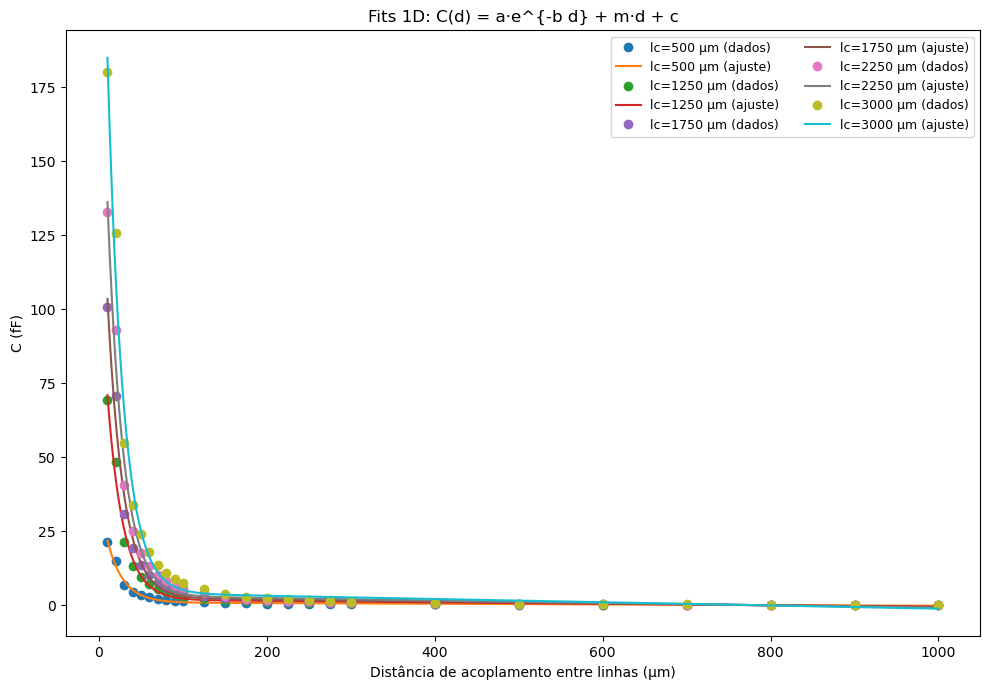


Parâmetros globais (modelo 2D):
  a0 = 1.62129e-07
  a1 = 0.100845
  b0 = 0.0592123
  b1 = -2.29999e-06
  m0 = 0.000600864
  m1 = -2.1275e-06
  c0 = -0.201206
  c1 = 0.00156082
R² global = 0.98849


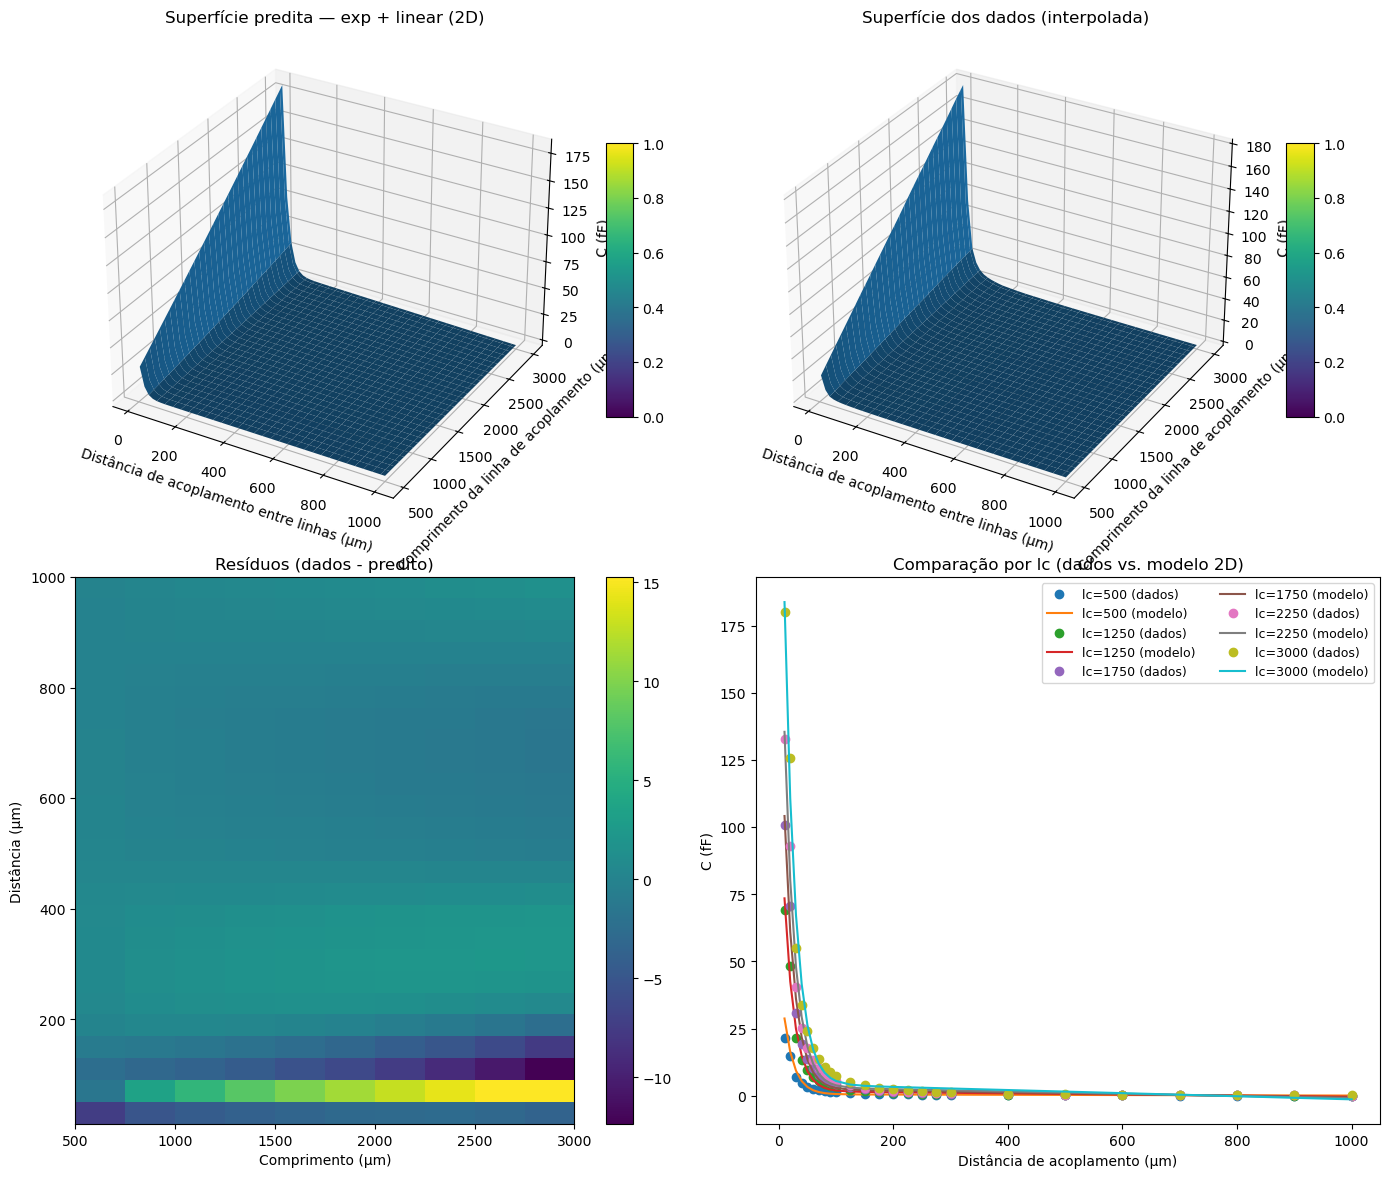

In [33]:
# ===== FIT exponencial + linear para (d3, lc3, C_values3) =====
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

Nd, Nl = C_values3.shape
assert Nd == d3.size and Nl == lc3.size, "Shapes inconsistentes entre C_values3, d3 e lc3."

# ---------- 1) Fit 1D por lc: C(d) = a*exp(-b*d) + m*d + c ----------
def model_1d(d_, a, b, m, c):
    return a * np.exp(-b * d_) + m * d_ + c

fits_1d = []
for j, lval in enumerate(lc3):
    y = C_values3[:, j]
    a0 = max(y.max() - y.min(), 1e-6)
    b0 = 1/300.0  # chute
    m0 = (y[-1] - y[0]) / (d3[-1] - d3[0])
    c0 = y.min()
    p0 = [a0, b0, m0, c0]
    bounds = ([0.0, 1e-9, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])
    popt, _ = curve_fit(model_1d, d3, y, p0=p0, bounds=(bounds[0], bounds[1]), maxfev=100000)
    fits_1d.append((lval, popt))

# Plot 1D (amostra de até 5 comprimentos)
plt.figure(figsize=(10, 7))
subset = np.linspace(0, Nl-1, min(Nl, 5), dtype=int)
for j in subset:
    y = C_values3[:, j]
    popt = [p for L, p in fits_1d if np.isclose(L, lc3[j])][0]
    d_dense = np.linspace(d3.min(), d3.max(), 400)
    plt.plot(d3, y, "o", label=f"lc={lc3[j]} µm (dados)")
    plt.plot(d_dense, model_1d(d_dense, *popt), "-", label=f"lc={lc3[j]} µm (ajuste)")
plt.xlabel("Distância de acoplamento entre linhas (µm)")
plt.ylabel("C (fF)")
plt.title("Fits 1D: C(d) = a·e^{-b d} + m·d + c")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# ---------- 2) Fit 2D global ----------
# Modelo: A(l)=a0+a1*l; B(l)=b0+b1*l; M(l)=m0+m1*l; C0(l)=c0+c1*l
def model_2d_flat(X, a0,a1, b0,b1, m0,m1, c0,c1):
    d_, l_ = X
    A  = a0 + a1*l_
    B  = b0 + b1*l_
    M  = m0 + m1*l_
    Cc = c0 + c1*l_
    return (A*np.exp(-B*d_) + M*d_ + Cc).ravel()

# Dados no grid original
D_grid, L_grid = np.meshgrid(d3, lc3, indexing="ij")  # (Nd, Nl)
Y = C_values3.ravel()

# Chutes iniciais a partir das médias dos fits 1D
a_list, b_list, m_list, c_list = zip(*[p for L, p in fits_1d])
a0_init = max(np.mean(a_list), 1e-6)
b0_init = max(np.mean(b_list), 1e-6)
m0_init = np.mean(m_list)
c0_init = np.mean(c_list)
p0_global = [a0_init, 0.0, b0_init, 0.0, m0_init, 0.0, c0_init, 0.0]

# Bounds (como tupla!)
lower = [0.0, -np.inf, 1e-9, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf]
upper = [np.inf,  np.inf,  np.inf,  np.inf,  np.inf,  np.inf,  np.inf,  np.inf]

popt2, pcov2 = curve_fit(
    model_2d_flat, (D_grid, L_grid), Y,
    p0=p0_global, bounds=(lower, upper), method="trf", maxfev=200000
)

# Métricas
Y_hat = model_2d_flat((D_grid, L_grid), *popt2)
ss_res = np.sum((Y - Y_hat)**2)
ss_tot = np.sum((Y - np.mean(Y))**2)
r2 = 1 - ss_res/ss_tot

print("\nParâmetros globais (modelo 2D):")
for name, val in zip(["a0","a1","b0","b1","m0","m1","c0","c1"], popt2):
    print(f"  {name:>2} = {val:.6g}")
print(f"R² global = {r2:.5f}")

# ----- Visualização: superfície predita vs. dados (interpolados) -----
d_dense = np.linspace(d3.min(), d3.max(), 60)
l_dense = np.linspace(lc3.min(), lc3.max(), 60)
D_dense, L_dense = np.meshgrid(d_dense, l_dense, indexing="ij")
C_pred_dense = model_2d_flat((D_dense, L_dense), *popt2).reshape(D_dense.shape)

# Interpolar dados para comparação visual
points = np.column_stack([D_grid.ravel(), L_grid.ravel()])
C_interp_dense = griddata(points, C_values3.ravel(), (D_dense, L_dense), method="cubic")

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(221, projection="3d")
surf = ax.plot_surface(D_dense, L_dense, C_pred_dense, edgecolor="none")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel("Distância de acoplamento entre linhas (µm)")
ax.set_ylabel("Comprimento da linha de acoplamento (µm)")
ax.set_zlabel("C (fF)")
ax.set_title("Superfície predita — exp + linear (2D)")

ax2 = fig.add_subplot(222, projection="3d")
surf2 = ax2.plot_surface(D_dense, L_dense, C_interp_dense, edgecolor="none")
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
ax2.set_xlabel("Distância de acoplamento entre linhas (µm)")
ax2.set_ylabel("Comprimento da linha de acoplamento (µm)")
ax2.set_zlabel("C (fF)")
ax2.set_title("Superfície dos dados (interpolada)")

# Resíduos no grid original
residuals = (C_values3 - model_2d_flat((D_grid, L_grid), *popt2).reshape(D_grid.shape))
ax3 = fig.add_subplot(223)
im = ax3.imshow(residuals, origin="lower",
                extent=[lc3.min(), lc3.max(), d3.min(), d3.max()],
                aspect="auto")
fig.colorbar(im, ax=ax3)
ax3.set_xlabel("Comprimento (µm)")
ax3.set_ylabel("Distância (µm)")
ax3.set_title("Resíduos (dados - predito)")

# Curvas C(d) para alguns lc comparando dados vs. modelo 2D
ax4 = fig.add_subplot(224)
for j in subset:
    y = C_values3[:, j]
    yhat = model_2d_flat((d3, np.full_like(d3, lc3[j])), *popt2)
    ax4.plot(d3, y, "o", label=f"lc={lc3[j]:.0f} (dados)")
    ax4.plot(d3, yhat, "-", label=f"lc={lc3[j]:.0f} (modelo)")
ax4.set_xlabel("Distância de acoplamento (µm)")
ax4.set_ylabel("C (fF)")
ax4.set_title("Comparação por lc (dados vs. modelo 2D)")
ax4.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


# Modelo 4

In [26]:
# -*- coding: utf-8 -*-
# Varre todos os .txt na pasta "Modelo 3", extrai C[trace_CAP32][trace_CAP31] por gap
# e acrescenta a coluna length_mm (extraído do nome do arquivo). Gera um CSV agregando tudo.

import re
import json
import pandas as pd
from pathlib import Path

# ======== CONFIG: ajuste só esta linha se sua pasta for outra ========
base_dir = Path("/Users/valentinaspohr/Desktop/tudo/unicamp/2s:2024/rouxinol/Projeto-Valentina-main 10/Inductive couplers/Modelo 4")

# ======== HELPERS ========
def parse_matrix_block(mat_text: str):
    """Lê a matriz impressa em texto:
       1ª linha = cabeçalhos (ex.: ground_main_plane trace_CAP41 trace_CAP42)
       Demais = 'row_label  n1  n2  n3' """
    lines = [ln.rstrip() for ln in mat_text.strip().splitlines() if ln.strip()]
    if not lines:
        return None
    header = re.split(r"\s+", lines[0].strip())
    table = {}
    for ln in lines[1:]:
        parts = re.split(r"\s+", ln.strip())
        if len(parts) >= 4:
            row_label = parts[0]
            vals = [float(x) for x in parts[1:4]]
            table[row_label] = dict(zip(header, vals))
    return table

def extract_c42_c41_from_matrix(mat_text: str):
    """Retorna explicitamente C[trace_CAP22][trace_CAP21]."""
    tb = parse_matrix_block(mat_text)
    if not tb:
        return float("nan")
    return tb.get("trace_CAP42", {}).get("trace_CAP41", float("nan"))

def extract_length_from_name(name: str):
    m = re.search(r"length\s*=\s*([0-9]*\.?[0-9]+)\s*mm", name, flags=re.I)
    return float(m.group(1)) if m else None

# ======== LOOP EM TODOS OS .TXT ========
records = []
txt_files = sorted(base_dir.glob("*.txt"))

for file_path in txt_files:
    text = file_path.read_text(encoding="utf-8", errors="ignore")
    length_mm = extract_length_from_name(file_path.name)

    # Percorre todos os blocos "XXum:" e pega o bloco de 'capacitance': ( ... , 'fF')
    idx = 0
    while True:
        m_gap = re.search(r"(\d+)\s*um\s*:", text[idx:], flags=re.I)
        if not m_gap:
            break
        gap_um = int(m_gap.group(1))
        start = idx + m_gap.end()

        m_mat = re.search(
            r"capacitance'\s*:\s*\(\s*(.*?)\s*,\s*['\"]fF['\"]\s*\)",
            text[start:], flags=re.S | re.I
        )
        if not m_mat:
            # avança para procurar o próximo gap
            idx = start
            continue

        mat_text = m_mat.group(1)
        C_cross = extract_c42_c41_from_matrix(mat_text)  # CAP32 ↔ CAP31

        records.append({
            "source_file": file_path.name,
            "length_mm": length_mm,
            "gap_um": gap_um,
            "C_trace_CAP42__trace_CAP41_fF": C_cross,
        })

        # avança o cursor após o bloco de capacitância encontrado
        idx = start + m_mat.end()

# ======== DF FINAL ========
df = pd.DataFrame.from_records(records)
# ordena por arquivo, depois length, depois gap
if not df.empty:
    df = df.sort_values(["source_file", "length_mm", "gap_um"], kind="mergesort").reset_index(drop=True)

display({"n_files": len(txt_files), "rows": len(df)})
df
# -*- coding: utf-8 -*-
# Varre todos os .txt na pasta "Modelo 3", extrai C[trace_CAP32][trace_CAP31] por gap
# e acrescenta a coluna length_mm (extraído do nome do arquivo). Gera um CSV agregando tudo.

import re
import json
import pandas as pd
from pathlib import Path

# ======== CONFIG: ajuste só esta linha se sua pasta for outra ========
base_dir = Path("/Users/valentinaspohr/Desktop/tudo/unicamp/2s:2024/rouxinol/Projeto-Valentina-main 10/Inductive couplers/Modelo 4")

# ======== HELPERS ========
def parse_matrix_block(mat_text: str):
    """Lê a matriz impressa em texto:
       1ª linha = cabeçalhos (ex.: ground_main_plane trace_CAP41 trace_CAP42)
       Demais = 'row_label  n1  n2  n3' """
    lines = [ln.rstrip() for ln in mat_text.strip().splitlines() if ln.strip()]
    if not lines:
        return None
    header = re.split(r"\s+", lines[0].strip())
    table = {}
    for ln in lines[1:]:
        parts = re.split(r"\s+", ln.strip())
        if len(parts) >= 4:
            row_label = parts[0]
            vals = [float(x) for x in parts[1:4]]
            table[row_label] = dict(zip(header, vals))
    return table

def extract_c42_c41_from_matrix(mat_text: str):
    """Retorna explicitamente C[trace_CAP32][trace_CAP31]."""
    tb = parse_matrix_block(mat_text)
    if not tb:
        return float("nan")
    return tb.get("trace_CAP42", {}).get("trace_CAP41", float("nan"))

def extract_length_from_name(name: str):
    m = re.search(r"length\s*=\s*([0-9]*\.?[0-9]+)\s*mm", name, flags=re.I)
    return float(m.group(1)) if m else None

# ======== LOOP EM TODOS OS .TXT ========
records = []
txt_files = sorted(base_dir.glob("*.txt"))

for file_path in txt_files:
    text = file_path.read_text(encoding="utf-8", errors="ignore")
    length_mm = extract_length_from_name(file_path.name)

    # Percorre todos os blocos "XXum:" e pega o bloco de 'capacitance': ( ... , 'fF')
    idx = 0
    while True:
        m_gap = re.search(r"(\d+)\s*um\s*:", text[idx:], flags=re.I)
        if not m_gap:
            break
        gap_um = int(m_gap.group(1))
        start = idx + m_gap.end()

        m_mat = re.search(
            r"capacitance'\s*:\s*\(\s*(.*?)\s*,\s*['\"]fF['\"]\s*\)",
            text[start:], flags=re.S | re.I
        )
        if not m_mat:
            # avança para procurar o próximo gap
            idx = start
            continue

        mat_text = m_mat.group(1)
        C_cross = extract_c42_c41_from_matrix(mat_text)  # CAP32 ↔ CAP31

        records.append({
            "source_file": file_path.name,
            "length_mm": length_mm,
            "gap_um": gap_um,
            "C_trace_CAP42__trace_CAP41_fF": C_cross,
        })

        # avança o cursor após o bloco de capacitância encontrado
        idx = start + m_mat.end()

# ======== DF FINAL ========
df = pd.DataFrame.from_records(records)
# ordena por arquivo, depois length, depois gap
if not df.empty:
    df = df.sort_values(["source_file", "length_mm", "gap_um"], kind="mergesort").reset_index(drop=True)

display({"n_files": len(txt_files), "rows": len(df)})
df


{'n_files': 20, 'rows': 250}

{'n_files': 20, 'rows': 250}

source_file  length_mm  gap_um  \
0    Modelo 4, length=0.5mm, gap=10-300um.txt        0.5    1725   
1    Modelo 4, length=0.5mm, gap=10-300um.txt        0.5    1750   
2    Modelo 4, length=0.5mm, gap=10-300um.txt        0.5    1775   
3    Modelo 4, length=0.5mm, gap=10-300um.txt        0.5    1825   
4    Modelo 4, length=0.5mm, gap=10-300um.txt        0.5    1850   
..                                        ...        ...     ...   
245                  Modelo 4, length=3mm.txt        3.0    1600   
246                  Modelo 4, length=3mm.txt        3.0    1700   
247                  Modelo 4, length=3mm.txt        3.0    1800   
248                  Modelo 4, length=3mm.txt        3.0    1900   
249                  Modelo 4, length=3mm.txt        3.0    1990   

     C_trace_CAP42__trace_CAP41_fF  
0                         -0.43643  
1                         -0.49883  
2                         -0.56920  
3                         -0.77127  
4                         -0.93060  
..                             ...  
245                       -0.93940  
246                       -1.46974  
247                       -2.73590  
248                       -8.18013  
249                     -180.69709  

[250 rows x 4 columns]

In [27]:
import numpy as np
import pandas as pd

# partindo do DataFrame df já processado
df4 = df.copy()
df4["gap_um"] = 2000 - df2["gap_um"]                # aplica transformação
df4["cap_fF"] = df4["C_trace_CAP42__trace_CAP41_fF"].abs()  # valores positivos
df4["length_um"] = (df4["length_mm"] * 1000).astype(int)

# gaps únicos e lengths únicos
d4  = np.sort(df4["gap_um"].astype(int))
lc4 = np.sort(df4["length_um"].astype(int))

# pivot: linhas = gaps, colunas = lengths
pivot = df4.pivot_table(index="gap_um", columns="length_um", values="cap_fF", aggfunc="first")
pivot = pivot.reindex(index=d4, columns=lc4)   # garante ordem

C_values4 = pivot.to_numpy()   # shape (len(d4), len(lc4))

print("d4 =", d4)
print("lc4 =", lc4)
print("C_values4 shape:", C_values4)


d4 = [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1100 1100 1100 1100
 1100 1100 1100 1100 1100 1100 1200 1200 1200 1200 1200 1200 1200 1200
 1200 1200 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1400 1400
 1400 1400 1400 1400 1400 1400 1400 1400 1500 1500 1500 1500 1500 1500
 1500 1500 1500 1500 1600 1600 1600 1600 1600 1600 1600 1600 1600 1600
 1700 1700 1700 1700 1700 1700 1700 1700 1700 1700 1725 1725 1725 1725
 1725 1725 1725 1725 1725 1725 1750 1750 1750 1750 1750 1750 1750 1750
 1750 1750 1775 1775 1775 1775 1775 1775 1775 1775 1775 1775 1800 1800
 1800 1800 1800 1800 1800 1800 1800 1800 1825 1825 1825 1825 1825 1825
 1825 1825 1825 1825 1850 1850 1850 1850 1850 1850 1850 1850 1850 1850
 1875 1875 1875 1875 1875 1875 1875 1875 1875 1875 1900 1900 1900 1900
 1900 1900 1900 1900 1900 1900 1910 1910 1910 1910 1910 1910 1910 1910
 1910 1910 1920 1920 1920 1920 1920 1920 1920 1920 1920 1920 1930 1930
 1930 1930 1930 1930 1930 1930 1930 1930 1940 1940 1940 1940 1940 1940
 

d4 (gaps) -> (25,)  | lc4 (lengths) -> (10,)  | C_values4 -> (25, 10)


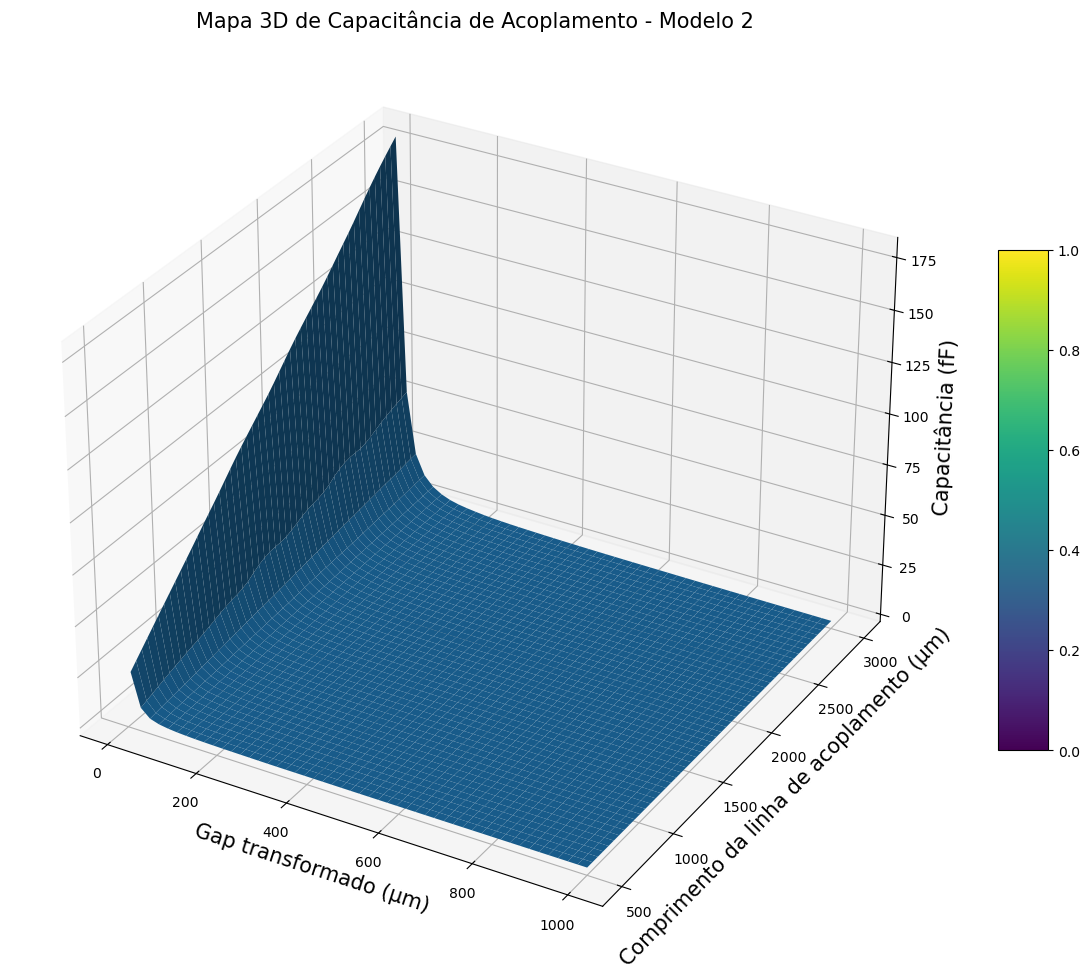

In [28]:
# ==== construir d3, lc3, C_values3 a partir do df ====
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Partindo do DataFrame df com colunas:
# 'length_mm', 'gap_um', 'C_trace_CAP22__trace_CAP21_fF'
df4 = df.copy()

# 1) transformar gap e deixar capacitância positiva
df4["gap_um"] = 2000 - df4["gap_um"]                             # gap transformado
df4["cap_fF"] = df4["C_trace_CAP42__trace_CAP41_fF"].abs()       # positivos
df4["length_um"] = (df4["length_mm"] * 1000).round().astype(int) # mm -> µm

# 2) montar e ordenar eixos
d4  = np.sort(df4["gap_um"].unique().astype(int))   # gaps (µm) transformados
lc4 = np.sort(df4["length_um"].unique().astype(int))# lengths (µm)

# 3) pivotar para matriz (linhas=gaps, colunas=lengths)
pivot = df4.pivot_table(index="gap_um", columns="length_um", values="cap_fF", aggfunc="first")
pivot = pivot.reindex(index=d4, columns=lc4)
C_values4 = pivot.to_numpy(dtype=float)             # shape: (len(d4), len(lc4))

print("d4 (gaps) ->", d4.shape, " | lc4 (lengths) ->", lc4.shape, " | C_values4 ->", C_values4.shape)

# ==== Método do Diego (com os valores acima) ====

# Grade regular para interpolação
D, Lc = np.meshgrid(
    np.linspace(d4.min(),  d4.max(),  50),   # eixo gaps (µm) transformados
    np.linspace(lc4.min(), lc4.max(), 50)    # eixo lengths (µm)
)

# Pontos conhecidos (casados com o shape de C_values3)
D_pts, Lc_pts = np.meshgrid(d4, lc4, indexing='ij')  # D_pts: (len(d4), len(lc4))
points = np.column_stack([D_pts.ravel(), Lc_pts.ravel()])
values = C_values4.ravel()

# Interpolação
C_interp = griddata(points, values, (D, Lc), method='cubic')

# Plot
fig = plt.figure(figsize=(15, 13))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(D, Lc, C_interp, edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

ax.set_xlabel('Gap transformado (µm)', fontsize=15)
ax.set_ylabel('Comprimento da linha de acoplamento (µm)', fontsize=15)
ax.set_zlabel('Capacitância (fF)', fontsize=15)
ax.set_title('Mapa 3D de Capacitância de Acoplamento - Modelo 2', fontsize=15)
plt.show()


d4 shape: (25,) | lc4 shape: (10,) | C_values4 shape: (25, 10)


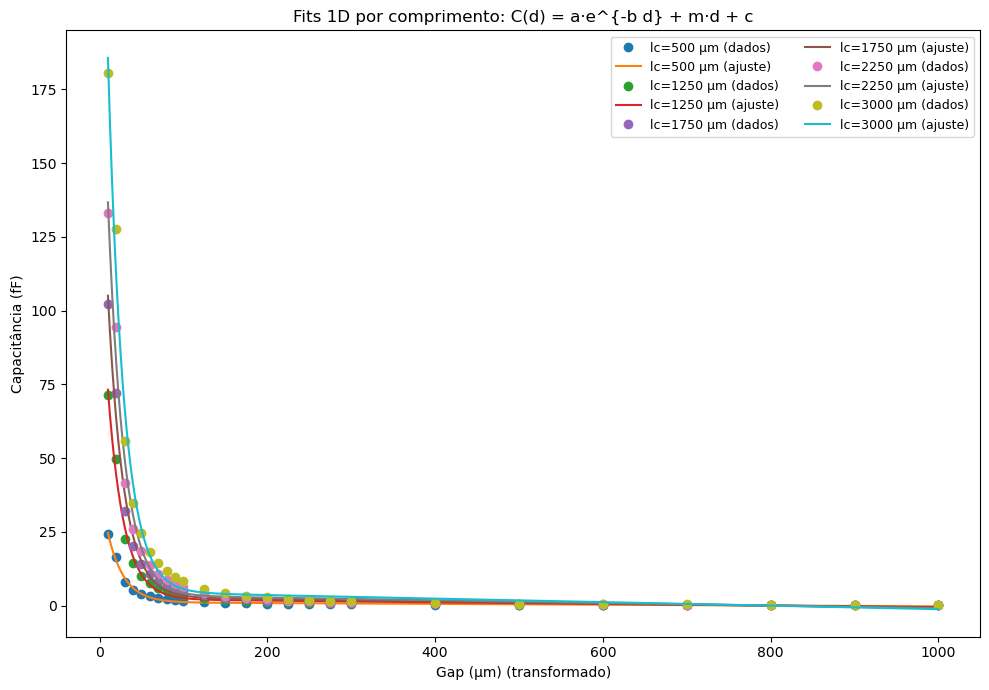


Parâmetros globais (modelo 2D) — Modelo 4:
  a0 = 5.40193e-13
  a1 = 0.101175
  b0 = 0.0571405
  b1 = -1.59517e-06
  m0 = 0.000110839
  m1 = -2.10661e-06
  c0 = 0.0805561
  c1 = 0.00159939
R² global = 0.98861


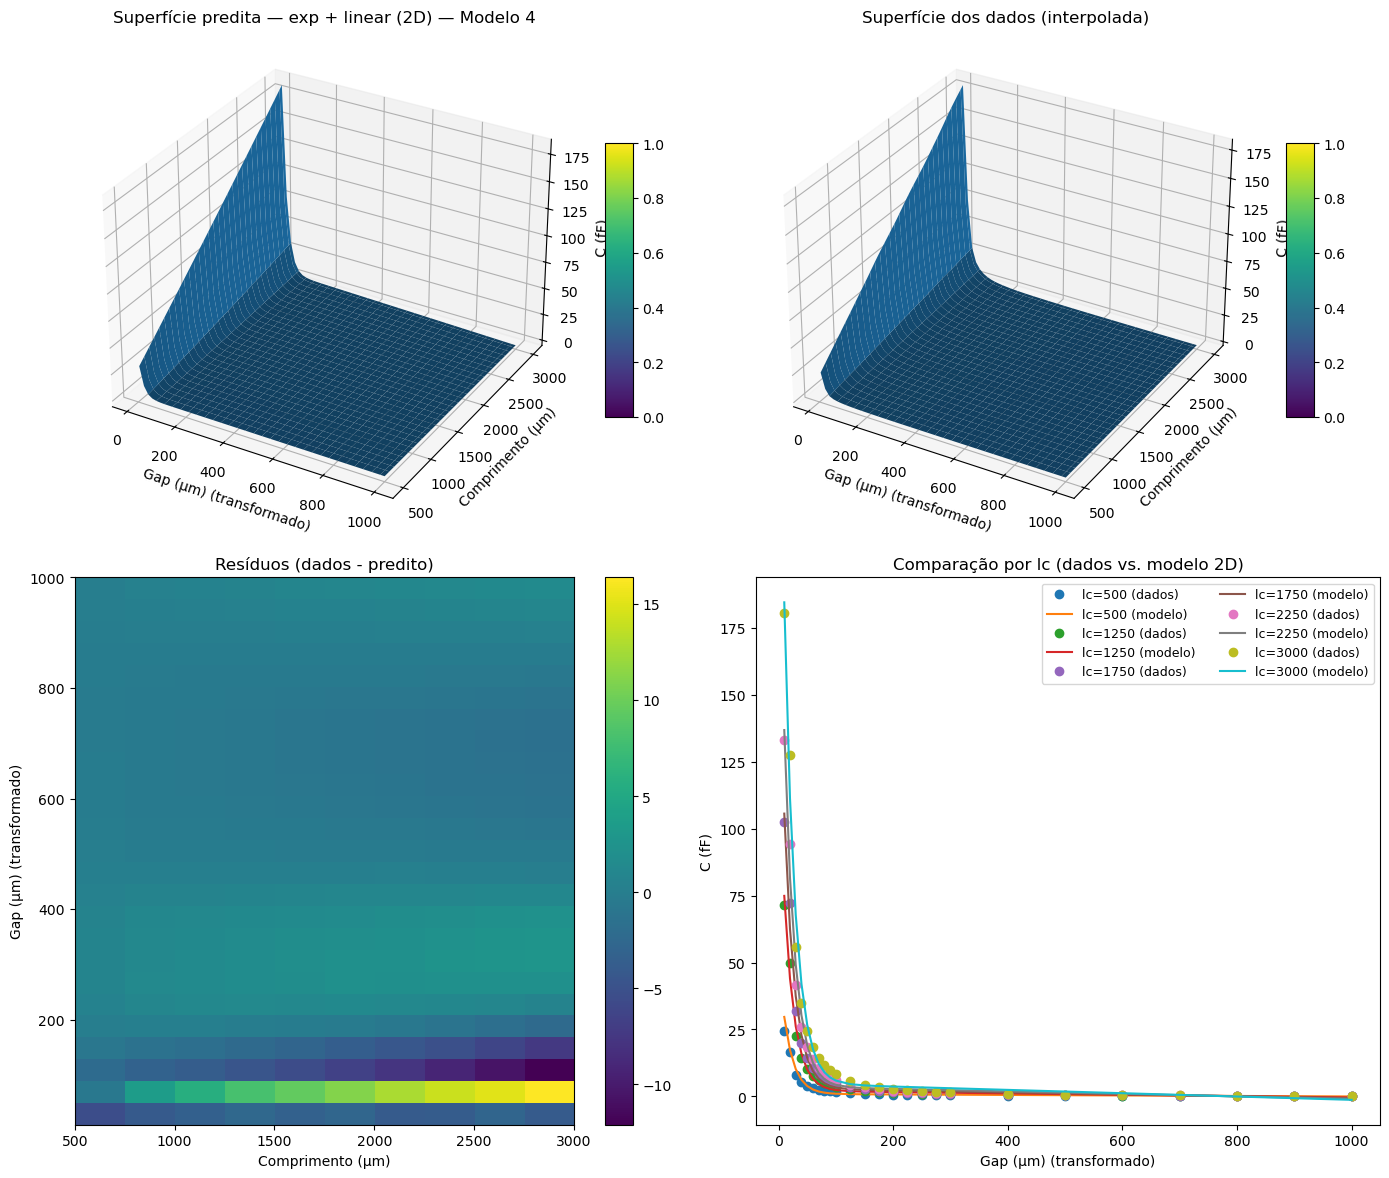

In [34]:
# ==== Modelo 4: construir d4, lc4, C_values4 a partir do df e ajustar (exp + linear) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---------- CONFIG ----------
gap_transform = True   # se True, usa gap' = 2000 - gap; se False, usa o gap original

# ---------- 0) Preparar df ----------
# Espera-se que 'df' já exista com colunas: length_mm, gap_um, C_trace_CAP42__trace_CAP41_fF
df4 = df.copy()
if gap_transform:
    df4["gap_um"] = 2000 - df4["gap_um"]          # transformação pedida
df4["cap_fF"] = df4["C_trace_CAP42__trace_CAP41_fF"].abs()  # capacitâncias positivas
df4["length_um"] = (df4["length_mm"] * 1000).round().astype(int)

# ---------- 1) Eixos e matriz ----------
d4  = np.sort(df4["gap_um"].unique().astype(int))              # gaps (µm)
lc4 = np.sort(df4["length_um"].dropna().unique().astype(int))  # lengths (µm)

pivot4 = df4.pivot_table(index="gap_um", columns="length_um", values="cap_fF", aggfunc="first")
pivot4 = pivot4.reindex(index=d4, columns=lc4)
C_values4 = pivot4.to_numpy(dtype=float)                       # linhas = d4, colunas = lc4

print("d4 shape:", d4.shape, "| lc4 shape:", lc4.shape, "| C_values4 shape:", C_values4.shape)

# ---------- 2) Fits 1D: C(d) = a*exp(-b*d) + m*d + c ----------
def model_1d(d_, a, b, m, c):
    return a * np.exp(-b * d_) + m * d_ + c

Nd, Nl = C_values4.shape
assert Nd == d4.size and Nl == lc4.size, "Shapes inconsistentes entre C_values4, d4, lc4."

fits_1d = []
for j, L in enumerate(lc4):
    y = C_values4[:, j]
    a0 = max(y.max() - y.min(), 1e-6)
    b0 = 1/300.0
    m0 = (y[-1] - y[0]) / (d4[-1] - d4[0])
    c0 = y.min()
    p0 = [a0, b0, m0, c0]
    bounds = ([0.0, 1e-9, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])
    popt, _ = curve_fit(model_1d, d4, y, p0=p0, bounds=(bounds[0], bounds[1]), maxfev=100000)
    fits_1d.append((L, popt))

# — Plot 1D de até 5 comprimentos
plt.figure(figsize=(10, 7))
subset = np.linspace(0, Nl-1, min(Nl, 5), dtype=int)
for j in subset:
    y = C_values4[:, j]
    popt = [p for L, p in fits_1d if np.isclose(L, lc4[j])][0]
    d_dense = np.linspace(d4.min(), d4.max(), 400)
    plt.plot(d4, y, "o", label=f"lc={lc4[j]} µm (dados)")
    plt.plot(d_dense, model_1d(d_dense, *popt), "-", label=f"lc={lc4[j]} µm (ajuste)")
plt.xlabel("Gap (µm)" + (" (transformado)" if gap_transform else ""))
plt.ylabel("Capacitância (fF)")
plt.title("Fits 1D por comprimento: C(d) = a·e^{-b d} + m·d + c")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# ---------- 3) Fit 2D global ----------
# Parâmetros variam linearmente com o comprimento:
# A(l)=a0+a1 l, B(l)=b0+b1 l, M(l)=m0+m1 l, C0(l)=c0+c1 l
def model_2d_flat(X, a0,a1, b0,b1, m0,m1, c0,c1):
    d_, l_ = X
    A  = a0 + a1*l_
    B  = b0 + b1*l_
    M  = m0 + m1*l_
    Cc = c0 + c1*l_
    return (A*np.exp(-B*d_) + M*d_ + Cc).ravel()

# Dados no grid original
D_grid, L_grid = np.meshgrid(d4, lc4, indexing="ij")
Y = C_values4.ravel()

# Chutes iniciais das médias dos 1D
a_list, b_list, m_list, c_list = zip(*[p for L, p in fits_1d])
a0_init = max(np.mean(a_list), 1e-6)
b0_init = max(np.mean(b_list), 1e-6)
m0_init = np.mean(m_list)
c0_init = np.mean(c_list)
p0_global = [a0_init, 0.0, b0_init, 0.0, m0_init, 0.0, c0_init, 0.0]

lower = [0.0, -np.inf, 1e-9, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf]
upper = [np.inf,  np.inf,  np.inf,  np.inf,  np.inf,  np.inf,  np.inf,  np.inf]

popt2, pcov2 = curve_fit(
    model_2d_flat, (D_grid, L_grid), Y,
    p0=p0_global, bounds=(lower, upper), method="trf", maxfev=200000
)

# Métricas
Y_hat = model_2d_flat((D_grid, L_grid), *popt2)
ss_res = np.sum((Y - Y_hat)**2)
ss_tot = np.sum((Y - np.mean(Y))**2)
r2 = 1 - ss_res/ss_tot

print("\nParâmetros globais (modelo 2D) — Modelo 4:")
for name, val in zip(["a0","a1","b0","b1","m0","m1","c0","c1"], popt2):
    print(f"  {name:>2} = {val:.6g}")
print(f"R² global = {r2:.5f}")

# ---------- 4) Visualizações ----------
# Malha densa
d_dense = np.linspace(d4.min(), d4.max(), 60)
l_dense = np.linspace(lc4.min(), lc4.max(), 60)
D_dense, L_dense = np.meshgrid(d_dense, l_dense, indexing="ij")
C_pred_dense = model_2d_flat((D_dense, L_dense), *popt2).reshape(D_dense.shape)

# Interpolar dados para comparar visualmente
points = np.column_stack([D_grid.ravel(), L_grid.ravel()])
C_interp_dense = griddata(points, C_values4.ravel(), (D_dense, L_dense), method="cubic")

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(221, projection="3d")
surf = ax.plot_surface(D_dense, L_dense, C_pred_dense, edgecolor="none")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel("Gap (µm)" + (" (transformado)" if gap_transform else ""))
ax.set_ylabel("Comprimento (µm)")
ax.set_zlabel("C (fF)")
ax.set_title("Superfície predita — exp + linear (2D) — Modelo 4")

ax2 = fig.add_subplot(222, projection="3d")
surf2 = ax2.plot_surface(D_dense, L_dense, C_interp_dense, edgecolor="none")
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
ax2.set_xlabel("Gap (µm)" + (" (transformado)" if gap_transform else ""))
ax2.set_ylabel("Comprimento (µm)")
ax2.set_zlabel("C (fF)")
ax2.set_title("Superfície dos dados (interpolada)")

# Resíduos no grid original
residuals = (C_values4 - model_2d_flat((D_grid, L_grid), *popt2).reshape(D_grid.shape))
ax3 = fig.add_subplot(223)
im = ax3.imshow(residuals, origin="lower",
                extent=[lc4.min(), lc4.max(), d4.min(), d4.max()],
                aspect="auto")
fig.colorbar(im, ax=ax3)
ax3.set_xlabel("Comprimento (µm)")
ax3.set_ylabel("Gap (µm)" + (" (transformado)" if gap_transform else ""))
ax3.set_title("Resíduos (dados - predito)")

# Curvas C(d) para alguns lc comparando dados vs. modelo 2D
ax4 = fig.add_subplot(224)
for j in subset:
    y = C_values4[:, j]
    yhat = model_2d_flat((d4, np.full_like(d4, lc4[j])), *popt2)
    ax4.plot(d4, y, "o", label=f"lc={lc4[j]:.0f} (dados)")
    ax4.plot(d4, yhat, "-", label=f"lc={lc4[j]:.0f} (modelo)")
ax4.set_xlabel("Gap (µm)" + (" (transformado)" if gap_transform else ""))
ax4.set_ylabel("C (fF)")
ax4.set_title("Comparação por lc (dados vs. modelo 2D)")
ax4.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()
